In [1]:
import os

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import random
import torch
from torch import distributions as D

from torch.nn import functional as F
from prdepth.dataset import Dataset
import prdepth.utils as ut
from prdepth.net import DORN
from prdepth.net import ResNet101
from prdepth.net import VAE


In [2]:
# Training Hyper-Params (taken from github of original paper)

TLIST = 'data/NYUtrain.txt'
VLIST = 'data/NYUval.txt'

PSZ = 33
STRIDE = 8
LATENT_DIM = 128

SHIFT = (PSZ - 1) // STRIDE
FACTOR = 8 // STRIDE

H, W = 480, 640  # Original image size
IH, IW = 257, 353  # Input image size to DORN
OH, OW = (IH - 1) // 8 + 1, (IW - 1) // 8 + 1  # 33x45, output size of DORN
FH, FW = (OH - 1) * FACTOR + 1, (OW - 1) * \
    FACTOR + 1  # The size of feature tensor
HNPS, WNPS = FH - SHIFT, FW - SHIFT  # Number of patches

# Batch size for feature extractor (DORN) and VAE.
DORN_BSZ = 2
N_DORN_BATCH = 2
BSZ = DORN_BSZ * N_DORN_BATCH
ABSZ = BSZ * HNPS * WNPS

# Params for Adam
LR = 1e-4
BETA1 = 0.5
BETA2 = 0.9

# weight for KL divergence loss.
LMD = 1e-4

VALFREQ = 5e3
SAVEFREQ = 1e4
MAXITER = 1.5e5

# Run the sampler 10 times when val to generate 10 samples per-patch
VARIter = 10

WTS = 'wts'
DORN_PRETRAINED = 'wts/DORN_NYUv2.npz'

if not os.path.exists(WTS):
    os.makedirs(WTS)

# Check for saved weights & optimizer states
msave = ut.ckpter(WTS + '/iter_*.model.npz')
ssave = ut.ckpter(WTS + '/iter_*.state.npz')
ut.logopen(WTS + '/train.log')
niter = msave.iter


In [3]:
# Feature extraction network is DORN (ResNet-101 based), which is pre-trained
# and fixed when training the VAE.

ResNet = ResNet101.ResNet101()
SceneNet = DORN.DORN()

In [4]:
gt = torch.zeros(BSZ, H, W, 1, dtype=torch.float32, requires_grad=False)
patched_depth = torch.zeros(BSZ, HNPS, WNPS, PSZ * PSZ, dtype=torch.float32, requires_grad=False)
patched_mask = torch.zeros(BSZ, HNPS, WNPS, 1, dtype=torch.float32, requires_grad=False)

patched_pred = torch.zeros(VARIter, BSZ, HNPS, WNPS, PSZ * PSZ, dtype=torch.float32, requires_grad=False)
feature = torch.zeros(BSZ, OH, OW, 2560, dtype=torch.float32, requires_grad=False)

# Reading dataset

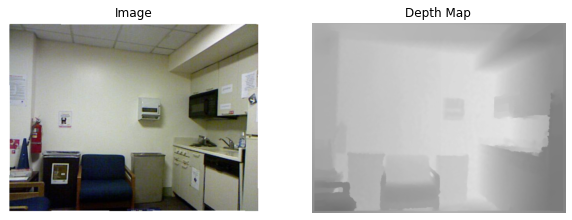

In [12]:
from matplotlib import pyplot as plt
import numpy as np
import h5py
## Visualization code from https://docs.h5py.org/en/stable/quick.html
# data path
path_to_depth = 'data/nyu_depth_v2_labeled.mat'

# read mat file
f = h5py.File(path_to_depth)

# read 0-th image. original format is [3 x 640 x 480], uint8
img = f['images'][0]

# reshape
img_ = np.empty([480, 640, 3])
img_[:,:,0] = img[0,:,:].T
img_[:,:,1] = img[1,:,:].T
img_[:,:,2] = img[2,:,:].T

# imshow
plt.figure(figsize=[10,20])
plt.subplot(121)
img__ = img_.astype('float32')
plt.imshow(img__/255.0)
plt.axis('off')
plt.title('Image')

# read corresponding depth (aligned to the image, in-painted) of size [640 x 480], float64
depth = f['depths'][0]

# reshape for imshow
depth_ = np.empty([480, 640, 3])
depth_[:,:,0] = depth[:,:].T
depth_[:,:,1] = depth[:,:].T
depth_[:,:,2] = depth[:,:].T

plt.subplot(122)
plt.imshow(depth_/4.0)
plt.axis('off')
plt.title('Depth Map')
plt.show()

In [34]:
img.shape

torch.Size([480, 640, 3])

In [51]:
#List the first 30 images as training images and the next 20 as validation
imgs = []
depths = []
for idx in range(50):
    rawimg = f['images'][idx]
    # reshape
    img = np.empty([480, 640, 3])
    img[:,:,0] = rawimg[0,:,:].T
    img[:,:,1] = rawimg[1,:,:].T
    img[:,:,2] = rawimg[2,:,:].T
    imgs.append(img.astype('float64'))
    
    
    rawdepth = f['depths'][0]

    # reshape for imshow
    depth = np.empty([480, 640, 3])
    depth[:,:,0] = rawdepth[:,:].T
    depth[:,:,1] = rawdepth[:,:].T
    depth[:,:,2] = rawdepth[:,:].T

    depths.append(depth.astype('float64'))
    
imgs = np.asarray(imgs)
depths = np.asarray(depths)
imgs = torch.from_numpy(imgs)
#Permute for interpolation
imgs = imgs.permute(0,3,1,2)
depths = torch.from_numpy(depths)
depths = depths.permute(0,3,1,2)


In [52]:
imgs.shape
depths.shape

torch.Size([50, 3, 480, 640])

In [55]:

DSdepths = F.interpolate(depths, [IH, IW],mode='bilinear', align_corners=True)
#Downsample to DORN resolution
DSimgs = F.interpolate(imgs, size=[IH, IW], mode='bilinear',align_corners=True)
#permute back to normal image shape
DSdepths = DSdepths.permute(0,2,3,1)
DSimgs = DSimgs.permute(0,2,3,1)

In [56]:
DSimgs.shape

torch.Size([50, 257, 353, 3])

## Create and instantiate dataloaders


In [57]:
class NYUv2Dataset(torch.utils.data.Dataset):
    def __init__(self, imgs, depths):
        self.imgs = imgs
        self.depths = depths

    def __len__(self):
        return len(self.imgs)

    # Note that bbox is in the form: upperX, upperY, lowerX, lowerY
    # Each img can have more than one bbox
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        img = self.imgs[index]
        depth = self.depth[index]
        sample = {'image': img, 'depth': depth}
        return sample

In [58]:
batch_size = 2
sequence = list(range(50))
random.shuffle(sequence)

data_set = NYUv2Dataset(imgs = imgs, 
                       depths = depths)
train_loader = torch.utils.data.DataLoader(
                 dataset=data_set,
                 batch_size=batch_size,
                 sampler=torch.utils.data.SubsetRandomSampler(sequence[:20]),
                 shuffle=False)
test_loader = torch.utils.data.DataLoader(
                dataset=data_set,
                batch_size=batch_size,
                sampler=torch.utils.data.SubsetRandomSampler(sequence[20:]),
                shuffle=False)

In [23]:
train_loader

In [27]:
patched_depth.shape

torch.Size([4, 29, 41, 1089])

In [29]:
gt = torch.zeros(BSZ, H, W, 1, dtype=torch.float32, requires_grad=False)
patched_depth = torch.zeros(BSZ, HNPS, WNPS, PSZ * PSZ, dtype=torch.float32, requires_grad=False)
patched_mask = torch.zeros(BSZ, HNPS, WNPS, 1, dtype=torch.float32, requires_grad=False)

patched_pred = torch.zeros(VARIter, BSZ, HNPS, WNPS, PSZ * PSZ, dtype=torch.float32, requires_grad=False)
feature = torch.zeros(BSZ, OH, OW, 2560, dtype=torch.float32, requires_grad=False)